<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update8_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 16.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Importing the Dataset & Exploring it

In [2]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '2y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
722,2022-01-22,36471.589844,36688.812500,34349.250000,35030.250000,39714385405,0,0
723,2022-01-23,35047.359375,36433.312500,34784.968750,36276.804688,26017975951,0,0
724,2022-01-24,36275.734375,37247.519531,33184.058594,36654.328125,41856658597,0,0
725,2022-01-25,36654.804688,37444.570312,35779.429688,36954.003906,26428189594,0,0
726,2022-01-26,36950.515625,38825.410156,36374.906250,36852.121094,31324598034,0,0
727,2022-01-27,36841.878906,37148.324219,35629.281250,37138.234375,25041426629,0,0
728,2022-01-28,37128.445312,37952.878906,36211.109375,37784.332031,22238830523,0,0
729,2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,0,0
730,2022-01-30,38151.917969,38266.339844,37437.710938,37917.601562,14643548444,0,0
731,2022-01-31,37922.519531,38647.261719,36747.328125,38453.218750,20781979648,0,0


In [3]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,732.000000,732.000000,732.000000,732.000000,7.320000e+02,732.0,732.0
mean,30577.308366,31401.066937,29652.340927,30610.484838,4.016250e+10,0.0,0.0
std,19344.987169,19854.526792,18731.914876,19324.533444,2.064346e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,1.225260e+10,0.0,0.0
25%,10305.641846,10492.340820,10137.011230,10320.845947,2.747029e+10,0.0,0.0
50%,33463.027344,34537.546875,32055.104492,33496.576172,3.620891e+10,0.0,0.0
75%,47780.924805,49161.133789,46678.666992,47729.456055,4.756835e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [4]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [5]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [6]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [7]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [8]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [20]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [10]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
727,2022-01-27,37138.234375
728,2022-01-28,37784.332031
729,2022-01-29,38138.179688
730,2022-01-30,37917.601562
731,2022-01-31,38453.218750


## Creating Facebook Prophet Model

In [11]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [12]:
periods = 30
future=m.make_future_dataframe(periods)

In [13]:
forecast=m.predict(future)

In [14]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-31,2338.483827,1554.181564,7927.517142,2338.483827,2338.483827,2396.271841,2396.271841,2396.271841,13.772318,13.772318,13.772318,2382.499523,2382.499523,2382.499523,0.0,0.0,0.0,4734.755668
1,2020-02-01,2462.871245,1632.876618,8545.841737,2462.871245,2462.871245,2598.956127,2598.956127,2598.956127,37.386466,37.386466,37.386466,2561.569661,2561.569661,2561.569661,0.0,0.0,0.0,5061.827372
2,2020-02-02,2587.258663,1950.981770,8584.414487,2587.258663,2587.258663,2819.027673,2819.027673,2819.027673,34.603074,34.603074,34.603074,2784.424598,2784.424598,2784.424598,0.0,0.0,0.0,5406.286336
3,2020-02-03,2711.646081,2554.256159,8949.044025,2711.646081,2711.646081,3061.821847,3061.821847,3061.821847,17.188071,17.188071,17.188071,3044.633775,3044.633775,3044.633775,0.0,0.0,0.0,5773.467928
4,2020-02-04,2836.033499,2609.279273,9450.789160,2836.033499,2836.033499,3243.237907,3243.237907,3243.237907,-91.834703,-91.834703,-91.834703,3335.072610,3335.072610,3335.072610,0.0,0.0,0.0,6079.271406
5,2020-02-05,2960.420917,3221.997136,9698.496869,2960.420917,2960.420917,3693.661692,3693.661692,3693.661692,45.582172,45.582172,45.582172,3648.079520,3648.079520,3648.079520,0.0,0.0,0.0,6654.082609
6,2020-02-06,3084.808335,3893.831105,10216.672149,3084.808335,3084.808335,3918.925692,3918.925692,3918.925692,-56.697398,-56.697398,-56.697398,3975.623090,3975.623090,3975.623090,0.0,0.0,0.0,7003.734026
7,2020-02-07,3209.195753,4268.508544,10610.008866,3209.195753,3209.195753,4323.247823,4323.247823,4323.247823,13.772318,13.772318,13.772318,4309.475505,4309.475505,4309.475505,0.0,0.0,0.0,7532.443576
8,2020-02-08,3333.583171,5028.234983,11384.580856,3333.583171,3333.583171,4678.774735,4678.774735,4678.774735,37.386466,37.386466,37.386466,4641.388269,4641.388269,4641.388269,0.0,0.0,0.0,8012.357906
9,2020-02-09,3457.970589,5327.389377,11840.092447,3457.970589,3457.970589,4997.869276,4997.869276,4997.869276,34.603074,34.603074,34.603074,4963.266202,4963.266202,4963.266202,0.0,0.0,0.0,8455.839865


In [15]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

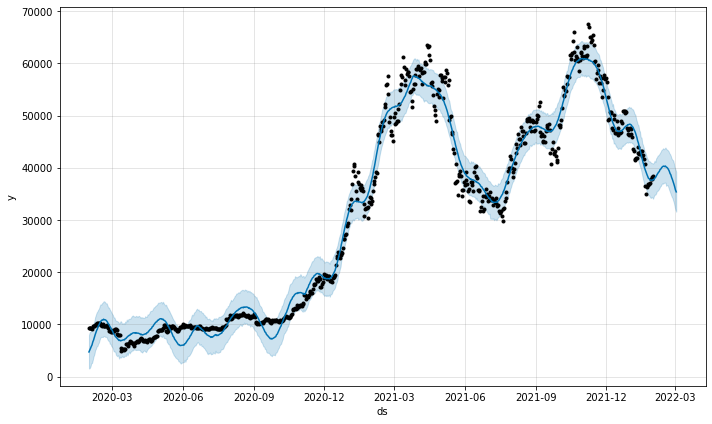

In [16]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

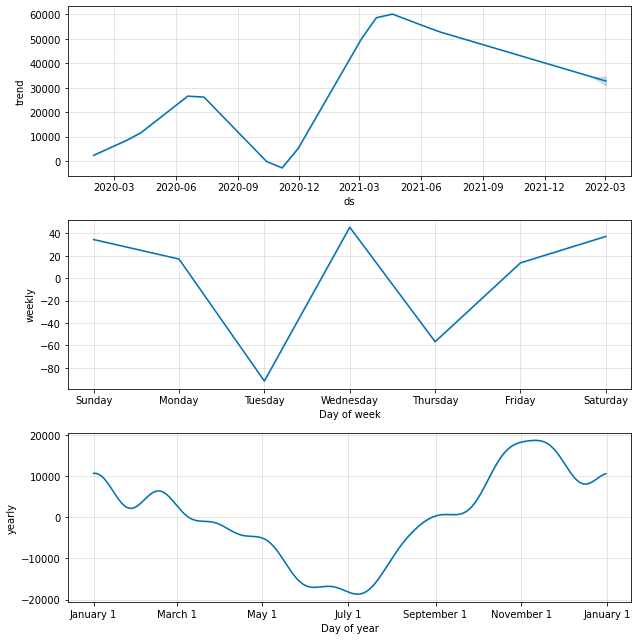

In [17]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>